In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
import cv2
from PIL import Image
from multiprocessing.pool import Pool

In [3]:
# Create array with all images
data_dir = 'kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/'
BATCH_SIZE = 64
from image_preprocessing import get_train_ds
IMG_SIZE = (150, 150)
dataset = pd.read_csv('kaggle/input/ukraine-ml-bootcamp-2023/train.csv').to_numpy()

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    zoom_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    rescale=1./255,
    validation_split=0.1)

In [5]:
train_data = train_generator.flow_from_directory(r'D:\kaggle_ua\train_ds', 
                                                 target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 subset="training"
                                                 )
val_data = train_generator.flow_from_directory(r'D:\kaggle_ua\train_ds', 
                                                 target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 subset='validation'
                                                 )

Found 2126 images belonging to 6 classes.
Found 234 images belonging to 6 classes.


# Model definition

In [6]:
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, SimpleRNN
model = keras.Sequential([
    # keras.Input((IMG_SIZE[0], IMG_SIZE[1], 1)),
    # keras.Input((33, 4, 1)),
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

In [7]:
from keras.applications import xception
xcept = xception.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=[IMG_SIZE[0], IMG_SIZE[1], 3],
    pooling='avg',
    classifier_activation="softmax",
)

In [8]:
for layer in xcept.layers[:110]:
    layer.trainable = False

In [9]:
model = keras.Sequential()
model.add(xcept)
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [10]:
xcept.layers[-1].output_shape

(None, 2048)

# Training the model

In [11]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint = keras.callbacks.ModelCheckpoint('model.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [12]:
learning_rate = 3e-5
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              metrics=["accuracy"])

In [13]:
history = model.fit(train_data,
                    steps_per_epoch=train_data.samples//BATCH_SIZE,
                    validation_steps=val_data.samples//BATCH_SIZE,
                    batch_size=BATCH_SIZE,
                    epochs=200,
                    validation_data=val_data,
                    callbacks=[checkpoint,early_stop])

Epoch 1/200
33/33 [==============================] - ETA: 0s - loss: 1.7590 - accuracy: 0.2481
Epoch 1: val_accuracy improved from -inf to 0.26042, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 45s 879ms/step - loss: 1.7590 - accuracy: 0.2481 - val_loss: 1.7070 - val_accuracy: 0.2604
Epoch 2/200
33/33 [==============================] - ETA: 0s - loss: 1.6785 - accuracy: 0.3078
Epoch 2: val_accuracy improved from 0.26042 to 0.38542, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 28s 852ms/step - loss: 1.6785 - accuracy: 0.3078 - val_loss: 1.5779 - val_accuracy: 0.3854
Epoch 3/200
33/33 [==============================] - ETA: 0s - loss: 1.5662 - accuracy: 0.3977
Epoch 3: val_accuracy did not improve from 0.38542
33/33 [==============================] - 9s 250ms/step - loss: 1.5662 - accuracy: 0.3977 - val_loss: 1.6745 - val_accuracy: 0.3542
Epoch 4/200
33/33 [==============================] - ETA: 0s - loss: 1.4751 - accuracy: 0.4432
Epoch 4: val_accuracy improved from 0.38542 to 0.41667, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 27s 845ms/step - loss: 1.4751 - accuracy: 0.4432 - val_loss: 1.4688 - val_accuracy: 0.4167
Epoch 5/200
33/33 [==============================] - ETA: 0s - loss: 1.3520 - accuracy: 0.4924
Epoch 5: val_accuracy improved from 0.41667 to 0.47917, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 24s 749ms/step - loss: 1.3520 - accuracy: 0.4924 - val_loss: 1.3811 - val_accuracy: 0.4792
Epoch 6/200
33/33 [==============================] - ETA: 0s - loss: 1.2560 - accuracy: 0.5426
Epoch 6: val_accuracy did not improve from 0.47917
33/33 [==============================] - 6s 181ms/step - loss: 1.2560 - accuracy: 0.5426 - val_loss: 1.3419 - val_accuracy: 0.4583
Epoch 7/200
33/33 [==============================] - ETA: 0s - loss: 1.1555 - accuracy: 0.5819
Epoch 7: val_accuracy improved from 0.47917 to 0.56250, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 26s 799ms/step - loss: 1.1555 - accuracy: 0.5819 - val_loss: 1.1594 - val_accuracy: 0.5625
Epoch 8/200
33/33 [==============================] - ETA: 0s - loss: 1.0501 - accuracy: 0.6166
Epoch 8: val_accuracy did not improve from 0.56250
33/33 [==============================] - 7s 195ms/step - loss: 1.0501 - accuracy: 0.6166 - val_loss: 1.1660 - val_accuracy: 0.5625
Epoch 9/200
33/33 [==============================] - ETA: 0s - loss: 0.9929 - accuracy: 0.6590
Epoch 9: val_accuracy did not improve from 0.56250
33/33 [==============================] - 6s 185ms/step - loss: 0.9929 - accuracy: 0.6590 - val_loss: 1.1900 - val_accuracy: 0.5625
Epoch 10/200
33/33 [==============================] - ETA: 0s - loss: 0.9136 - accuracy: 0.6724
Epoch 10: val_accuracy improved from 0.56250 to 0.61458, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 23s 702ms/step - loss: 0.9136 - accuracy: 0.6724 - val_loss: 0.9836 - val_accuracy: 0.6146
Epoch 11/200
33/33 [==============================] - ETA: 0s - loss: 0.9112 - accuracy: 0.6875
Epoch 11: val_accuracy did not improve from 0.61458
33/33 [==============================] - 6s 188ms/step - loss: 0.9112 - accuracy: 0.6875 - val_loss: 1.1315 - val_accuracy: 0.5938
Epoch 12/200
33/33 [==============================] - ETA: 0s - loss: 0.8359 - accuracy: 0.7064
Epoch 12: val_accuracy did not improve from 0.61458
33/33 [==============================] - 7s 198ms/step - loss: 0.8359 - accuracy: 0.7064 - val_loss: 1.0225 - val_accuracy: 0.6042
Epoch 13/200
33/33 [==============================] - ETA: 0s - loss: 0.7830 - accuracy: 0.7303
Epoch 13: val_accuracy did not improve from 0.61458
33/33 [==============================] - 7s 197ms/step - loss: 0.7830 - accuracy: 0.7303 - val_loss: 1.0786 - val_accuracy: 0.5938
Epoch 14/200
33/33 [===========

INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 23s 712ms/step - loss: 0.7720 - accuracy: 0.7197 - val_loss: 0.9660 - val_accuracy: 0.6458
Epoch 16/200
33/33 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.7563
Epoch 16: val_accuracy did not improve from 0.64583
33/33 [==============================] - 6s 173ms/step - loss: 0.6912 - accuracy: 0.7563 - val_loss: 1.1382 - val_accuracy: 0.6354
Epoch 17/200
33/33 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.7737
Epoch 17: val_accuracy improved from 0.64583 to 0.67708, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 30s 938ms/step - loss: 0.6630 - accuracy: 0.7737 - val_loss: 0.8280 - val_accuracy: 0.6771
Epoch 18/200
33/33 [==============================] - ETA: 0s - loss: 0.6161 - accuracy: 0.7900
Epoch 18: val_accuracy did not improve from 0.67708
33/33 [==============================] - 7s 201ms/step - loss: 0.6161 - accuracy: 0.7900 - val_loss: 0.9853 - val_accuracy: 0.6667
Epoch 19/200
33/33 [==============================] - ETA: 0s - loss: 0.6023 - accuracy: 0.7900
Epoch 19: val_accuracy did not improve from 0.67708
33/33 [==============================] - 6s 182ms/step - loss: 0.6023 - accuracy: 0.7900 - val_loss: 1.1113 - val_accuracy: 0.6042
Epoch 20/200
33/33 [==============================] - ETA: 0s - loss: 0.5767 - accuracy: 0.8040
Epoch 20: val_accuracy improved from 0.67708 to 0.72917, saving model to model.h15


INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 24s 738ms/step - loss: 0.5767 - accuracy: 0.8040 - val_loss: 0.9012 - val_accuracy: 0.7292
Epoch 21/200
33/33 [==============================] - ETA: 0s - loss: 0.5674 - accuracy: 0.7945
Epoch 21: val_accuracy did not improve from 0.72917
33/33 [==============================] - 6s 179ms/step - loss: 0.5674 - accuracy: 0.7945 - val_loss: 0.8611 - val_accuracy: 0.6458
Epoch 22/200
33/33 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.8267
Epoch 22: val_accuracy did not improve from 0.72917
33/33 [==============================] - 6s 184ms/step - loss: 0.5258 - accuracy: 0.8267 - val_loss: 0.9328 - val_accuracy: 0.6562
Epoch 23/200
33/33 [==============================] - ETA: 0s - loss: 0.5141 - accuracy: 0.8229
Epoch 23: val_accuracy did not improve from 0.72917
33/33 [==============================] - 6s 168ms/step - loss: 0.5141 - accuracy: 0.8229 - val_loss: 0.9114 - val_accuracy: 0.7083
Epoch 24/200
33/33 [===========

INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 22s 694ms/step - loss: 0.4871 - accuracy: 0.8267 - val_loss: 0.8866 - val_accuracy: 0.7396
Epoch 26/200
33/33 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.8494
Epoch 26: val_accuracy did not improve from 0.73958
33/33 [==============================] - 6s 171ms/step - loss: 0.4562 - accuracy: 0.8494 - val_loss: 0.9687 - val_accuracy: 0.6667
Epoch 27/200
33/33 [==============================] - ETA: 0s - loss: 0.4229 - accuracy: 0.8561
Epoch 27: val_accuracy did not improve from 0.73958
33/33 [==============================] - 6s 176ms/step - loss: 0.4229 - accuracy: 0.8561 - val_loss: 0.9910 - val_accuracy: 0.7083
Epoch 28/200
33/33 [==============================] - ETA: 0s - loss: 0.4300 - accuracy: 0.8671
Epoch 28: val_accuracy did not improve from 0.73958
33/33 [==============================] - 6s 180ms/step - loss: 0.4300 - accuracy: 0.8671 - val_loss: 1.0162 - val_accuracy: 0.6354
Epoch 29/200
33/33 [===========

INFO:tensorflow:Assets written to: model.h15\assets


INFO:tensorflow:Assets written to: model.h15\assets


33/33 [==============================] - 22s 682ms/step - loss: 0.2700 - accuracy: 0.9129 - val_loss: 0.7567 - val_accuracy: 0.7500
Epoch 41/200
33/33 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.9239
Epoch 41: val_accuracy did not improve from 0.75000
33/33 [==============================] - 6s 179ms/step - loss: 0.2705 - accuracy: 0.9239 - val_loss: 1.1183 - val_accuracy: 0.6875
Epoch 42/200
33/33 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.9094
Epoch 42: val_accuracy did not improve from 0.75000
33/33 [==============================] - 6s 187ms/step - loss: 0.2686 - accuracy: 0.9094 - val_loss: 1.1350 - val_accuracy: 0.6458
Epoch 43/200
33/33 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.9094
Epoch 43: val_accuracy did not improve from 0.75000
33/33 [==============================] - 6s 186ms/step - loss: 0.2725 - accuracy: 0.9094 - val_loss: 1.2163 - val_accuracy: 0.6354


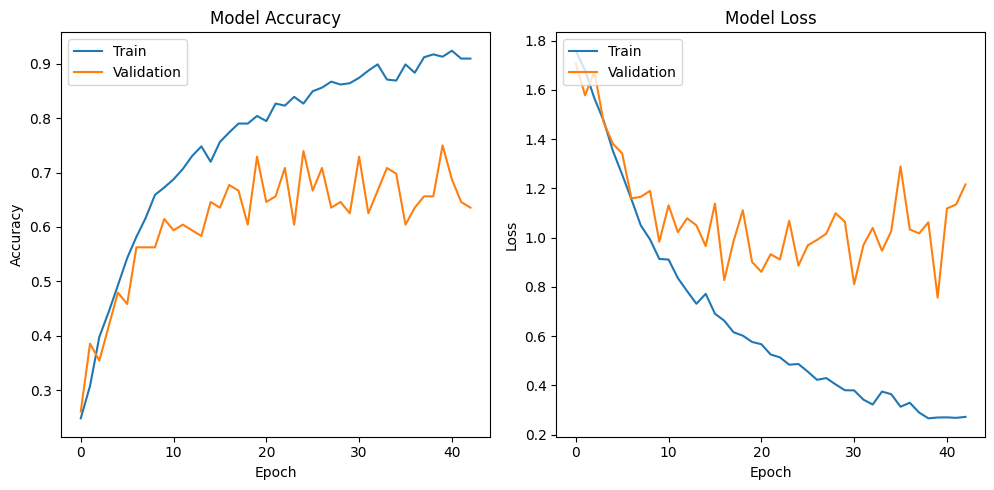

In [15]:
# Plot training & validation accuracy, F1 score, and loss values
plt.figure(figsize=(15, 5))

# Plotting Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Creating predictions submissions file

In [16]:
model.load_weights('model.h15')

In [17]:
from image_preprocessing import get_val_ds
# Load sample submission, change values to model forecasts
test_data_dir = 'kaggle/input/ukraine-ml-bootcamp-2023/images/test_images/'

df = pd.read_csv('kaggle/input/ukraine-ml-bootcamp-2023/sample_submission.csv')
df_np = pd.read_csv('kaggle/input/ukraine-ml-bootcamp-2023/sample_submission.csv').to_numpy()
images = get_val_ds(df_np, test_data_dir, IMG_SIZE)

In [18]:
for i, (name, cords) in enumerate(images):
    predictions = model.predict(np.array([cords]), verbose=0)[0]
    if i < 5:
        print(predictions)
    df.at[i,'class_6'] = np.argmax(predictions)

ValueError: in user code:

    File "d:\kaggle_ua\venv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "d:\kaggle_ua\venv\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\kaggle_ua\venv\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "d:\kaggle_ua\venv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "d:\kaggle_ua\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\kaggle_ua\venv\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 150, 150, 3), found shape=(None, 33, 4)


In [ ]:
df.to_csv('submission.csv', index=False)